In [100]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from dataloader.svdd_dataloader import CollionCollisionLoader_new
from nets.vaenet import FusionNet
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from utils.reconstruction_loss import ReconstructionLoss,CompactFeatureLoss,VAE_loss
from utils.initialization import initialize_center_c
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

train_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_test'
train_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_test'

test_audio = '/home/iot/collision_detect/new_data/audio_np/Abnormal'
test_imu = '/home/iot/collision_detect/new_data/imu_np/Abnormal'


checkpoint_path = '/home/iot/collision_detect/output/ours_VAE_1/model_1.pth'

workers = 4
batchsize = 64
dropout_rate = 0.3
kernel_num = 32
feature_dim = 128
num_class = 2
use_attention = 1
Epoch = 200


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = ReconstructionLoss()
loss_function = nn.MSELoss()


train_data = CollisionLoader_new(train_imu,train_audio,train=True)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

random_tensor = torch.load('/home/iot/collision_detect/random_center.pth').to(device)
print(random_tensor)
model = FusionNet(use_crossattention=use_attention, feature_dim=feature_dim, dropout_rate=dropout_rate, kernel_num=kernel_num, classes=num_class)
model = model.to(device)

if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
    print('Load weights')


cuda
tensor([ 1.3251, -0.9753, -1.4476,  1.1698,  0.5268,  0.8547,  1.1029, -0.3968,
         0.7179,  0.3071, -1.2956, -0.9488,  1.2269,  1.3339,  0.4070, -0.1396,
         1.1857,  0.2690,  0.0922, -3.2794, -0.0579, -0.4278,  0.5835,  0.5821,
        -1.7175, -1.0654, -0.0433,  0.2796, -1.0104,  2.1468,  0.0599,  2.3647,
        -1.5545, -0.7931,  0.4042,  0.8657, -0.7088, -1.7346,  1.6328, -0.3851,
         0.0499,  1.4968, -0.1872,  0.6864,  0.2222, -0.1285, -0.6068, -0.4344,
         2.6284,  0.8339,  2.4152,  0.5807, -0.2116,  0.1228,  0.5329, -0.4907,
         2.1077, -0.5446,  0.0710, -0.4846, -0.6830, -0.1345,  0.0902,  0.4794,
        -0.4977, -0.2547,  0.0139,  0.3283, -0.7060, -0.4270, -0.5369, -0.6628,
        -0.0477,  0.5294, -1.0924, -2.3342, -0.9479, -0.8486,  0.7766, -1.1619,
         1.3924, -0.2796, -0.9148, -1.0141,  0.1941, -1.3252,  0.5212,  0.8635,
         0.2209,  0.5948, -0.0999,  0.7029,  0.8589,  0.4629, -1.2594, -1.0929,
        -0.7298,  0.0925, -0.2037, 

Reconstruction Loss 0.0307
SVDd Loss for Sample: 0.0755


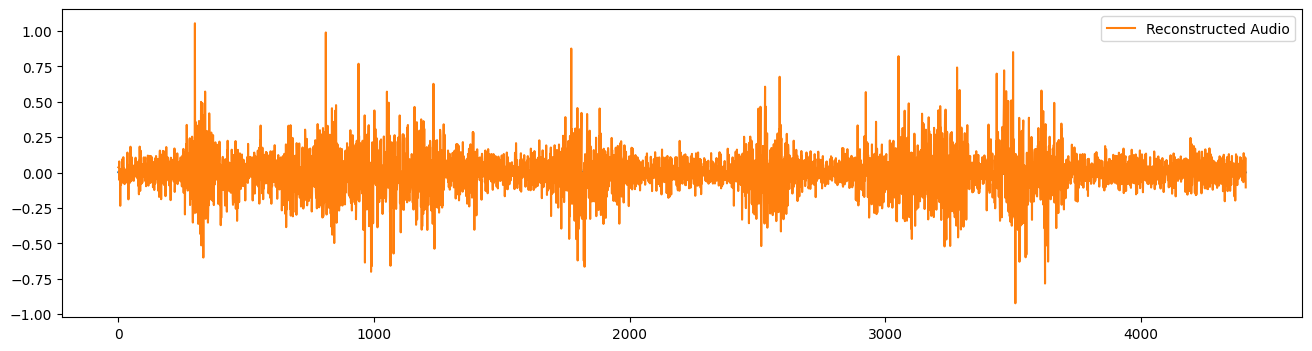

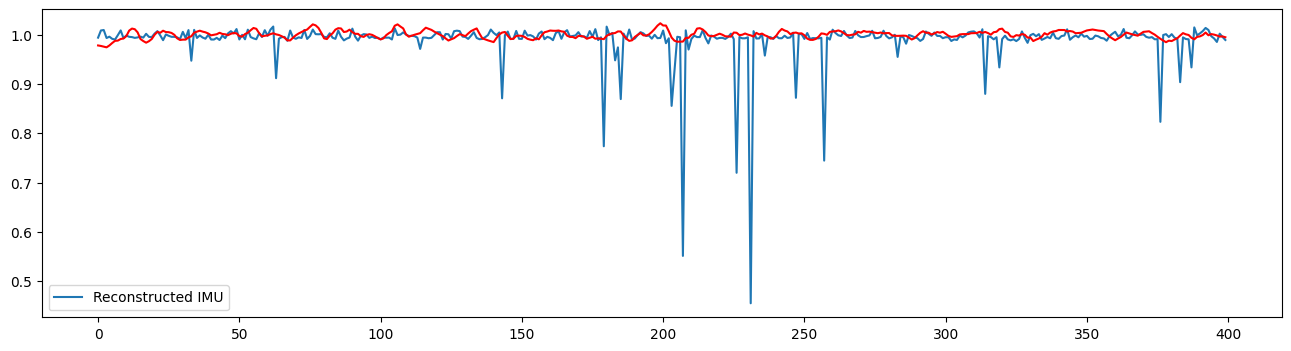

In [101]:
model.eval()
sample_idx = 6

# print(audio.shape)5
# Change this to the index of the sample you want to load
spec, image, audio,_,_ =train_data[sample_idx]
spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
recon_x1, recon_x2, mu1, logvar1, mu2, logvar2, z = model(audio, image)
# total_loss_all,reconstruction_loss,kloss,svdd_loss = VAE_loss(recon_x1, audio, recon_x2, image, mu1, logvar1, mu2, logvar2, z, random_tensor,1)
# total_loss = reconstruction_loss+svdd_loss
# anomaly_score, reconstructed_audio, reconstructed_imu= model(audio, image)
# print(anomaly_score.shape)
# reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio)
# target_zero = random_tensor.unsqueeze(0).expand(1, -1)
# svdd_loss = loss_function(anomaly_score, target_zero)
# total_loss = svdd_loss+reconstruction_loss


target_zero = random_tensor.unsqueeze(0).expand(1, -1)
# print(z.shape,target_zero.shape)
svdd_loss = loss_function(z, target_zero)

KLD1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
KLD2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())
KLD_loss = KLD1+KLD2

reconstruction_loss = reconstruction_loss_fn(image,recon_x2,audio, recon_x1)

total_loss = reconstruction_loss+svdd_loss



print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
print(f"SVDd Loss for Sample: {svdd_loss.item()*10:.4f}")
plt.figure(figsize=(16, 4))
plt.plot(audio.cpu().numpy().squeeze()[0])
plt.plot(recon_x1.cpu().detach().numpy().squeeze()[0], label='Reconstructed Audio')
plt.legend()

plt.figure(figsize=(16, 4))
plt.plot(recon_x2.cpu().detach().numpy().squeeze(), label='Reconstructed IMU')
plt.plot(image.cpu().numpy().squeeze(), 'r')
plt.legend()


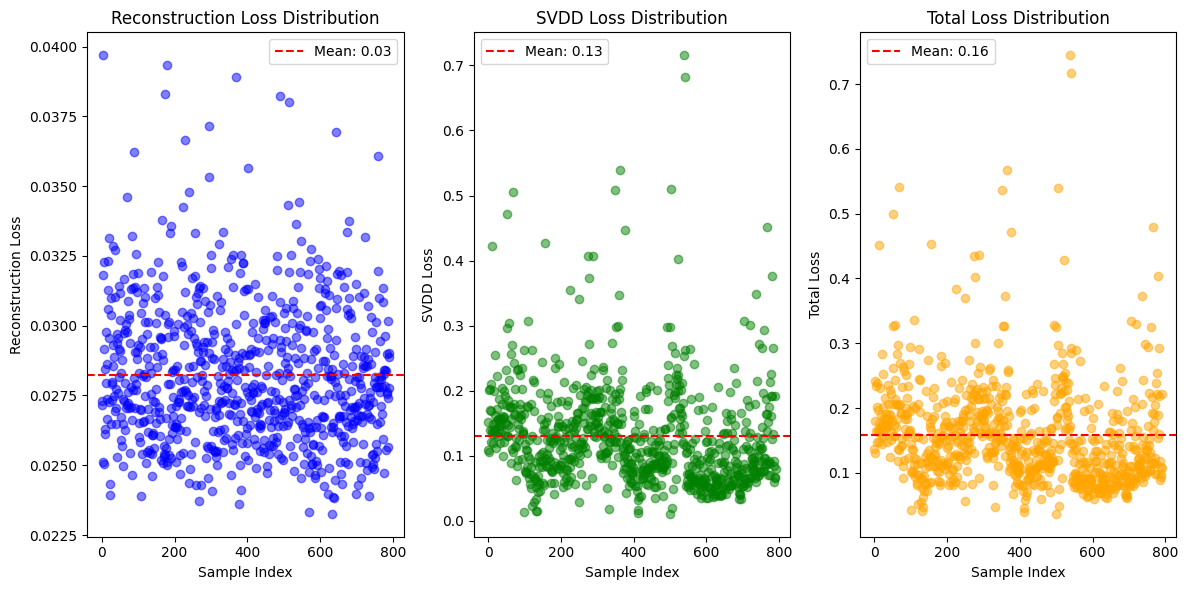

In [102]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_val = []
svdd_losses_val = []
total_losses_val = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, imu, audio,_,_ = val_data[sample_idx]
        spec, imu, audio = spec.unsqueeze(0).to(device), imu.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        recon_x1, recon_x2, mu1, logvar1, mu2, logvar2, z = model(audio, imu)
        # total_loss_all,reconstruction_loss,kloss,svdd_loss = VAE_loss(recon_x1, audio, recon_x2, image, mu1, logvar1, mu2, logvar2, z, random_tensor,1)
        target_zero = random_tensor.unsqueeze(0).expand(1, -1)
        # print(z.shape,target_zero.shape)
        svdd_loss = loss_function(z, target_zero)
        
        KLD1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
        KLD2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())
        KLD_loss = KLD1+KLD2
        
        reconstruction_loss = reconstruction_loss_fn(image,recon_x2,audio, recon_x1)
        
        total_loss = reconstruction_loss+svdd_loss
        reconstruction_losses_val.append(reconstruction_loss.item())
        svdd_losses_val.append(svdd_loss.item())
        total_losses_val.append(total_loss.item())
        total_sample+=1
        
mean_reconstruction_loss = sum(reconstruction_losses_val) / len(reconstruction_losses_val)
mean_svdd_loss = sum(svdd_losses_val) / len(svdd_losses_val)
mean_total_loss = sum(total_losses_val) / len(total_losses_val)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses_val, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses_val, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses_val), 0.32)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses_val, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses),2)
plt.legend()

plt.tight_layout()
plt.show()

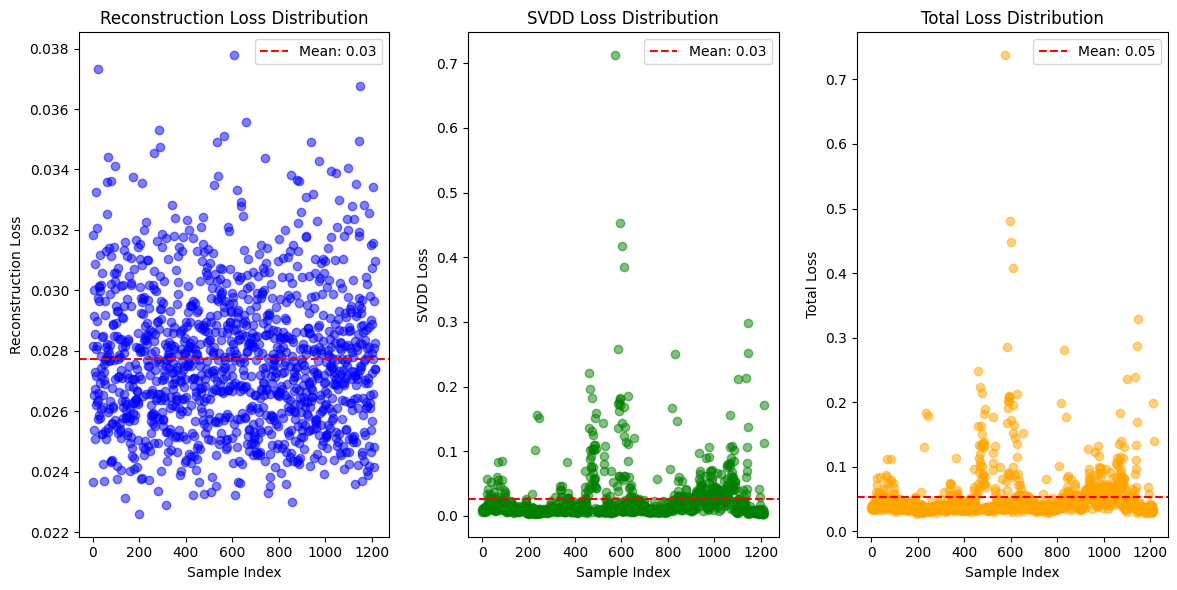

In [103]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_train = []
svdd_losses_train = []
total_losses_train = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, imu, audio,_,_ = train_data[sample_idx]
        spec, imu, audio = spec.unsqueeze(0).to(device), imu.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        recon_x1, recon_x2, mu1, logvar1, mu2, logvar2, z = model(audio, imu)
        # total_loss_all,reconstruction_loss,kloss,svdd_loss = VAE_loss(recon_x1, audio, recon_x2, image, mu1, logvar1, mu2, logvar2, z, random_tensor,1)
        target_zero = random_tensor.unsqueeze(0).expand(1, -1)
        # print(z.shape,target_zero.shape)
        svdd_loss = loss_function(z, target_zero)
        
        KLD1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
        KLD2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())
        KLD_loss = KLD1+KLD2
        
        reconstruction_loss = reconstruction_loss_fn(image,recon_x2,audio, recon_x1)
        
        total_loss = reconstruction_loss+svdd_loss
        reconstruction_losses_train.append(reconstruction_loss.item())
        svdd_losses_train.append(svdd_loss.item())
        total_losses_train.append(total_loss.item())
        total_sample+=1


mean_reconstruction_loss = sum(reconstruction_losses_train) / len(reconstruction_losses_train)
mean_svdd_loss = sum(svdd_losses_train) / len(svdd_losses_train)
mean_total_loss = sum(total_losses_train) / len(total_losses_train)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(train_data)), reconstruction_losses_train, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), max(reconstruction_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses_train, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)r
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(train_data)), total_losses_train, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses), max(total_losses)*1.1)
plt.legend()

plt.tight_layout()
plt.show()

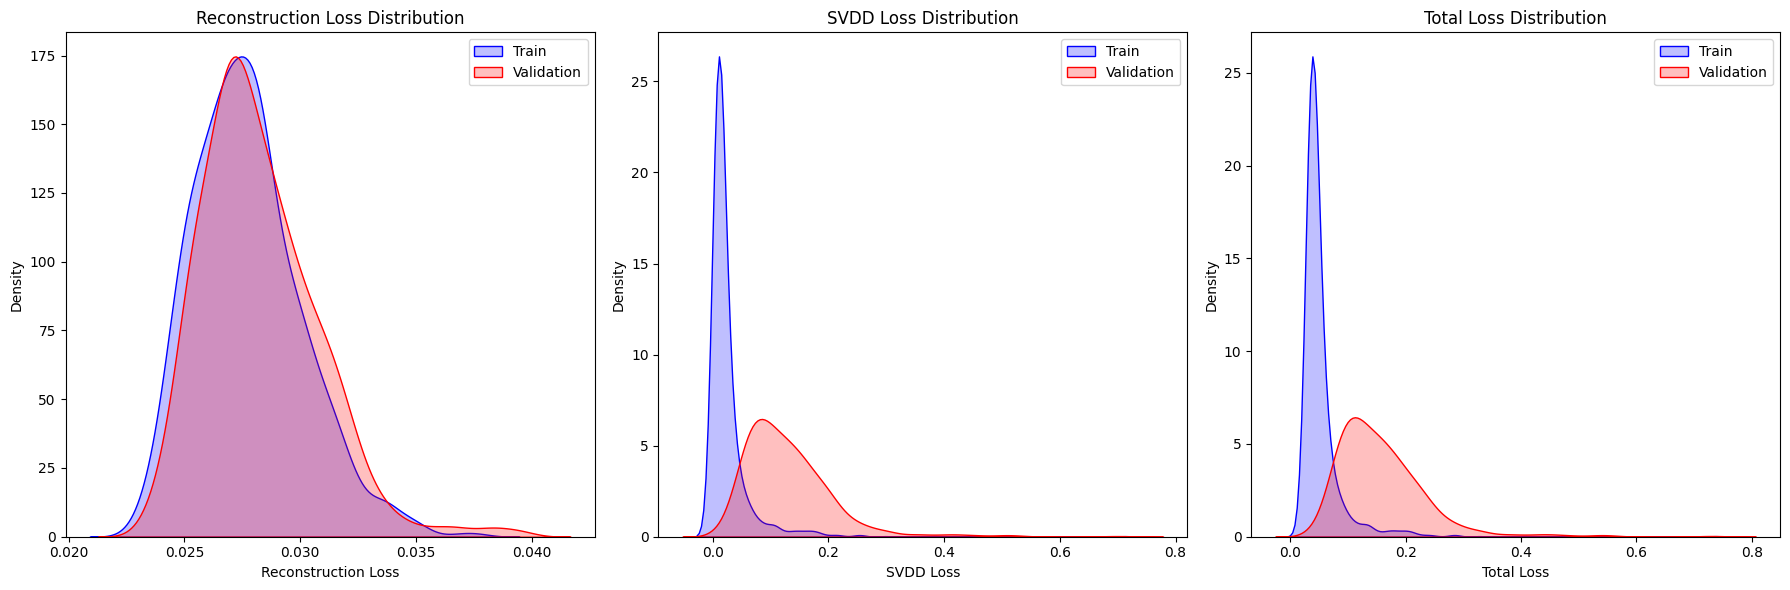

In [104]:
import seaborn as sns

# Plotting KDE plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(reconstruction_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(reconstruction_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(svdd_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(svdd_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 40)
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(total_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(total_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


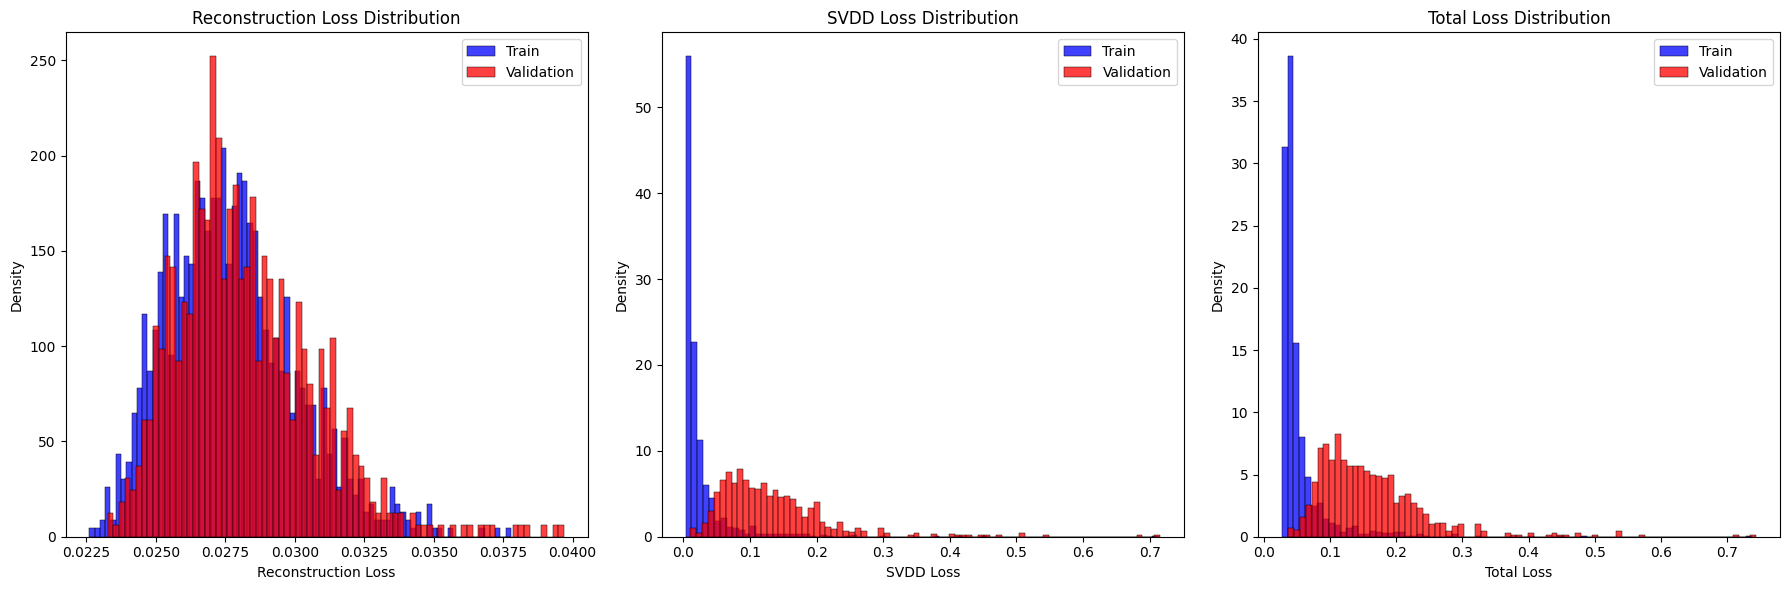

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting histograms
plt.figure(figsize=(18, 6))

# Plot for Reconstruction Loss Distribution
plt.subplot(1, 3, 1)
sns.histplot(reconstruction_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(reconstruction_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

# Plot for SVDD Loss Distribution
plt.subplot(1, 3, 2)
sns.histplot(svdd_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(svdd_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 0.4)
plt.legend()

# Plot for Total Loss Distribution
plt.subplot(1, 3, 3)
sns.histplot(total_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(total_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')

plt.legend()

plt.tight_layout()
plt.show()


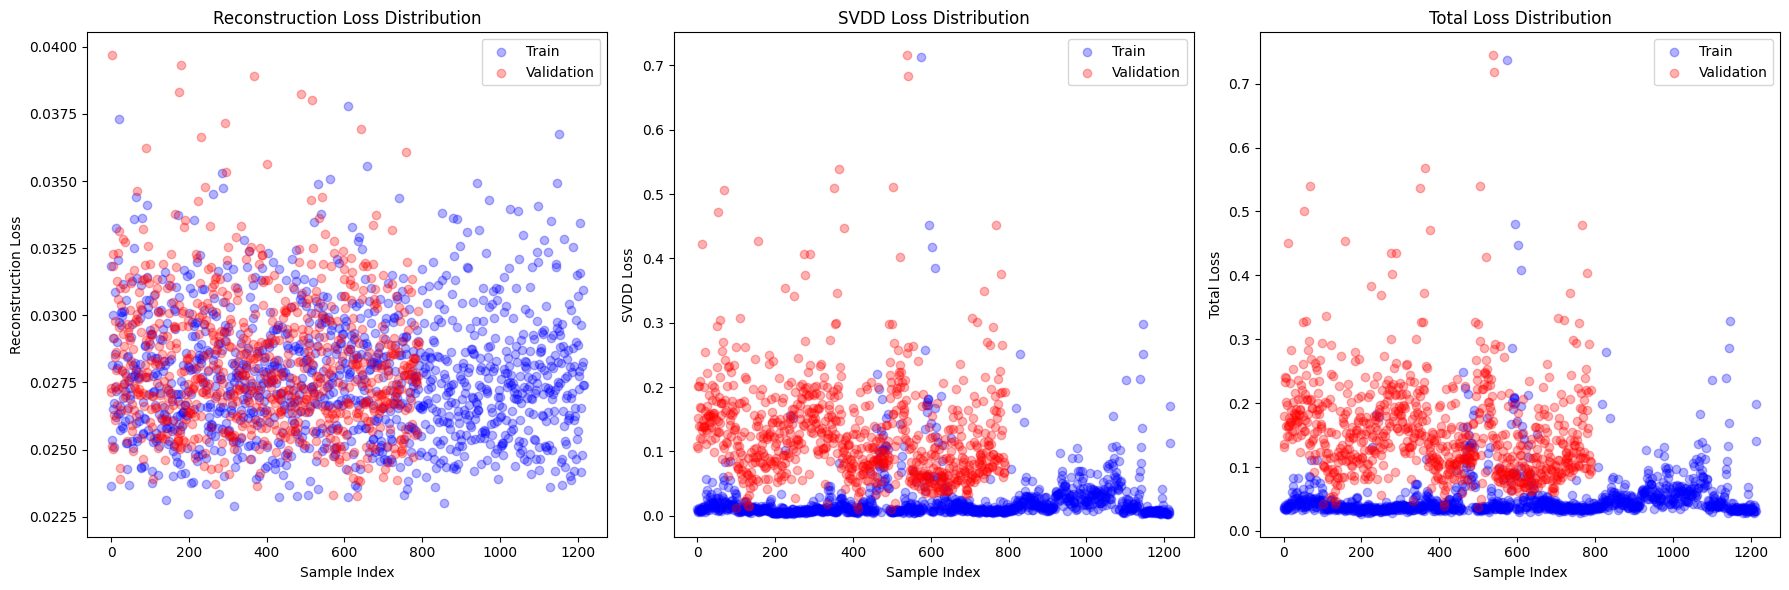

In [106]:
import matplotlib.pyplot as plt

# Plotting scatter plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(reconstruction_losses_train)), reconstruction_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(reconstruction_losses_val)), reconstruction_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(0,0.006)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(svdd_losses_train)), svdd_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(svdd_losses_val)), svdd_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
# plt.ylim(0,0.02)
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(total_losses_train)), total_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(total_losses_val)), total_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
# plt.ylim(0,0.06)
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


In [125]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data


loss_all_audio = svdd_losses_train+svdd_losses_val
loss_all_audio = np.array(loss_all_audio)
# loss_all_audio = z_score_normalization(loss_all_audio)


loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)
# loss_all_recons = z_score_normalization(loss_all_recons)

In [126]:
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [x + y for x, y in zip(loss_all_audio, loss_all_recons)]

In [127]:
eval_metrics_svdd = ts_metrics(labels_all, (loss_all_audio))
eval_metrics_recons = ts_metrics(labels_all, (loss_all_recons))
eval_metrics_all = ts_metrics(labels_all, (loss_all))

In [128]:
print(eval_metrics_svdd[:-2])
print(eval_metrics_recons[:-2])
print(eval_metrics_all[:-2])

(0.9519651697900053, 0.8838276410431951, 0.8930015891928353, 0.8479001135073779, 0.9431818181818182)
(0.5548557117224879, 0.4468799033044565, 0.5711044579706267, 0.40540540540540543, 0.9659090909090909)
(0.9519983967969164, 0.8835969100794842, 0.8948256768653251, 0.8451178451178452, 0.9507575757575758)


In [129]:
# np.save("/home/iot/collision_detect/svdd/ploting/vaesvdd_P",eval_metrics_svdd[-2])
# np.save("/home/iot/collision_detect/svdd/ploting/vaesvdd_r",eval_metrics_svdd[-1])

In [130]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (loss_all_audio))
epsilon = 1e-10

f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)
normal_list = train_data.audio_list
indoor_group = []
outdoor_group = []

for idx, filepath in enumerate(normal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    else:
        outdoor_group.append(idx)  # Add the index of the file
print(len(indoor_group),len(outdoor_group))
indoor_losses = [svdd_losses_train[idx] for idx in indoor_group]
outdoor_losses = [svdd_losses_train[idx] for idx in outdoor_group]

0.04720862954854965
642 574


In [131]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.8898

Indoor Group Accuracy:
  Accuracy: 0.8847

Outdoor Group Accuracy:
  Accuracy: 0.8955


In [132]:
abnormal_list = val_data.audio_list
mach_group = []
coli_group = []

for idx, filepath in enumerate(abnormal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    # file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file
        
mach_losses = [svdd_losses_val[idx] for idx in mach_group]
coli_losses = [svdd_losses_val[idx] for idx in coli_group]
print(len(mach_losses),len(coli_losses))

513 279


In [133]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")


Overall Accuracy:
  Accuracy: 0.9419

mach Group Accuracy:
  Accuracy: 0.9181

coli Group Accuracy:
  Accuracy: 0.9857


In [20]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data

loss_all = total_losses_train+total_losses_val
labels_all = np.concatenate([np.zeros(len(total_losses_train)),np.ones(len(total_losses_val))])
eval_metrics_all = ts_metrics(labels_all, (loss_all))
print(eval_metrics_all)

(0.9506805584334853, 0.9015602516696831, 0.8708308283090187, 0.7850368809272918, 0.9776902887139107)


In [28]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# model.eval()
# random_tensor = torch.load('center.pth').to(device)
# true_labels = []
# predicted_labels = []
# threshold = 0.45

# with torch.no_grad():
#     for sample_idx in range(len(val_data)):
#         spec, image, audio = val_data[sample_idx]

#         spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

#         anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

#         reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio, reconstructed_audio) * 10

#         target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

#         # Calculate SVDD loss for the sample
#         svdd_loss = loss_function(anomaly_score, target_zero)*100

#         # Calculate total loss for the sample
#         total_loss = svdd_loss + reconstruction_loss

#         # Predict class based on total loss
#         if svdd_loss<=mean_svdd_loss:
#             predicted_class=0
#         else:
#             predicted_class=1

#         # Handle ground truth class
#         true_class = 1

#         # Update confusion matrix variables
#         true_labels.append(true_class)
#         predicted_labels.append(predicted_class)

# # Construct confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# print("Confusion Matrix:")
# print(conf_matrix)


In [10]:
conf_matrix = np.array([[267, 105],[48, 278]])

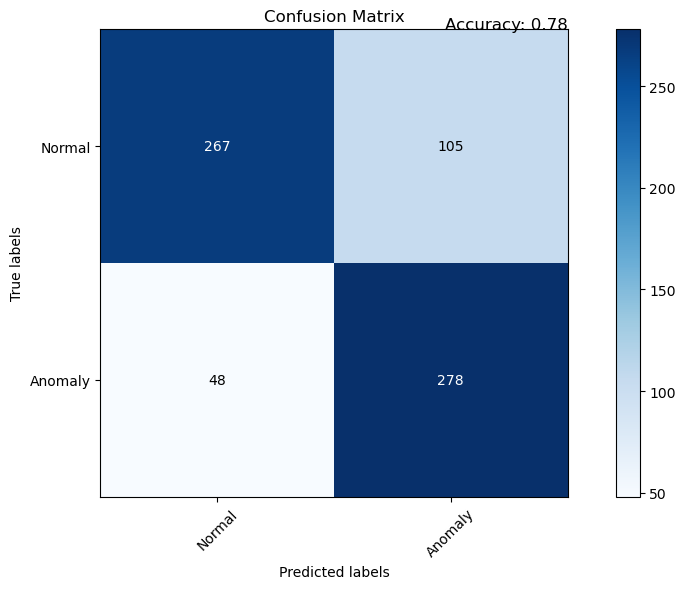

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Normal', 'Anomaly']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add counts to each cell
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Add accuracy to the plot
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', color='black', fontsize=12, horizontalalignment='right')

# Eliminate grid lines
plt.grid(False)

plt.tight_layout()
plt.show()


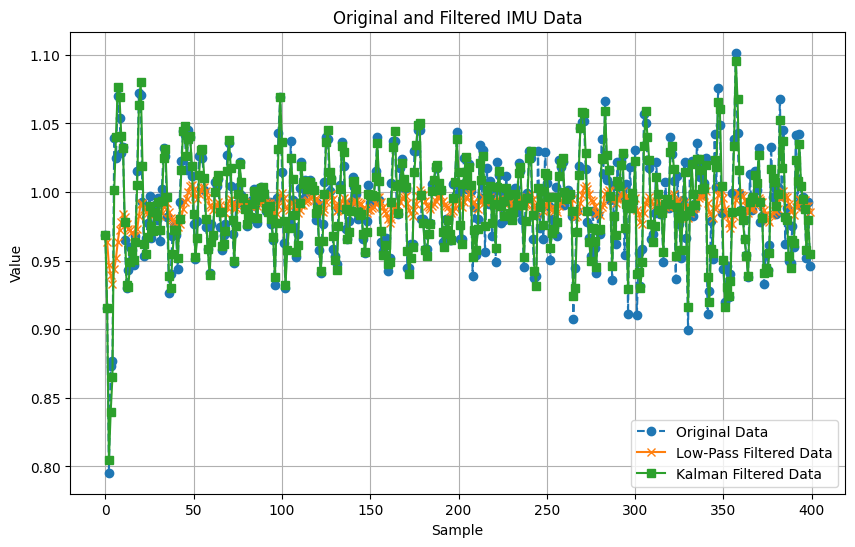

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Low-Pass Filter Class
class LowPassFilter:
    def __init__(self, alpha):
        self.alpha = alpha
        self.state = None

    def filter(self, value):
        if self.state is None:
            self.state = value
        else:
            self.state = self.alpha * value + (1 - self.alpha) * self.state
        return self.state

# Kalman Filter Function
def apply_kalman_filter(data, R, Q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # initial state (position and velocity)
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = R  # measurement noise
    kf.Q = Q  # process noise

    filtered_data = []

    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])  # we are interested in the position

    return np.array(filtered_data)

# Example IMU data (numpy array)
imu_data = np.load('/home/iot/collision_detect/new_data/imu_np/Normal_test/seq15/0.npy')[:,-1][:1000]
# Apply Low-Pass Filter
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in imu_data])

# Apply Kalman Filter
R = 0.1  # Example measurement noise
Q = 0.1  # Example process noise
kf_filtered_data = apply_kalman_filter(imu_data, R, Q)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(imu_data, label='Original Data', linestyle='--', marker='o')
plt.plot(lpf_filtered_data, label='Low-Pass Filtered Data', linestyle='-', marker='x')
plt.plot(kf_filtered_data, label='Kalman Filtered Data', linestyle='-', marker='s')

plt.title('Original and Filtered IMU Data')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
import torch
import torch.nn as nn

# Define the Conv1DFeatureExtractor model
class Conv1DFeatureExtractor(nn.Module):
    def __init__(self, input_channels, fc_output_dim=512, kernel_size=3):
        super(Conv1DFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)  
        self.conv2 = nn.Conv1d(32, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)  
        self.conv3 = nn.Conv1d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)  
        self.conv4 = nn.Conv1d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)  
        self.conv5 = nn.Conv1d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(64)  
        self.conv6 = nn.Conv1d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.bn6 = nn.BatchNorm1d(64)  
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, fc_output_dim)
        self.fc_bn = nn.BatchNorm1d(fc_output_dim)
        self.lstm  = nn.LSTM(6, 64, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        print(f'After conv1: {x.shape}')
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        print(f'After conv2: {x.shape}')
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        print(f'After conv3: {x.shape}')
        
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        print(f'After conv4: {x.shape}')
        
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        print(f'After conv5: {x.shape}')
        
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        print(f'After conv6: {x.shape}')
        
        x,_ = self.lstm(x)
        print(f'After LSTM: {x.shape}')
        
        x = x[:, -1, :]
        print(f'After taking last time step: {x.shape}')
        
        x = self.fc(x)
        print(f'After fully connected layer: {x.shape}')
        
        return x

# Define the DeconvModule model
class DeconvModule(nn.Module):
    def __init__(self, input_channels=64, output_channels=2, kernel_size=3, fc_output_dim=512):
        super(DeconvModule, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(64, 64, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.deconv2 = nn.ConvTranspose1d(64, 64, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.deconv3 = nn.ConvTranspose1d(64, 64, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.deconv4 = nn.ConvTranspose1d(64, 32, kernel_size=kernel_size, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm1d(32)
        self.deconv5 = nn.ConvTranspose1d(32, 32, kernel_size=kernel_size, stride=2, padding=2, output_padding=1)
        self.bn5 = nn.BatchNorm1d(32)
        self.deconv6 = nn.ConvTranspose1d(32, output_channels, kernel_size=kernel_size, stride=2, padding=2, output_padding=1)
        self.bn6 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU()
        self.fc_audio = nn.Linear(fc_output_dim, 64)
        self.lstm = nn.LSTM(1, 69, batch_first=True)
        
    def forward(self, x):
        bs, c = x.size()
        x = self.relu(self.fc_audio(x))
        print(f'After fully connected layer: {x.shape}')
        
        x, _ = self.lstm(x.unsqueeze(2))
        print(f'After LSTM: {x.shape}')
        
        x = self.relu(self.bn1(self.deconv1(x)))
        print(f'After deconv1: {x.shape}')
        
        x = self.relu(self.bn2(self.deconv2(x)))
        print(f'After deconv2: {x.shape}')
        
        x = self.relu(self.bn3(self.deconv3(x)))
        print(f'After deconv3: {x.shape}')
        
        x = self.relu(self.bn4(self.deconv4(x)))
        print(f'After deconv4: {x.shape}')
        
        x = self.relu(self.bn5(self.deconv5(x)))
        print(f'After deconv5: {x.shape}')
        
        x = self.deconv6(x)
        print(f'After deconv6: {x.shape}')
        
        return x


In [71]:
# Example input for Conv1DFeatureExtractor
batch_size = 32
input_channels = 1
sequence_length = 400
x = torch.randn(batch_size, input_channels, sequence_length)  # [32, 1, 400]

conv_model = Conv1DFeatureExtractor(input_channels)
conv_output = conv_model(x)
print(f'Final output of Conv1DFeatureExtractor: {conv_output.shape}')

# Example input for DeconvModule
batch_size = 32
input_channels = 512
x = torch.randn(batch_size, input_channels)  # [32, 64]

deconv_model = DeconvModule(64)
deconv_output = deconv_model(x)
print(f'Final output of DeconvModule: {deconv_output.shape}')


After conv1: torch.Size([32, 32, 200])
After conv2: torch.Size([32, 64, 100])
After conv3: torch.Size([32, 64, 50])
After conv4: torch.Size([32, 64, 25])
After conv5: torch.Size([32, 64, 12])
After conv6: torch.Size([32, 64, 6])
After LSTM: torch.Size([32, 64, 64])
After taking last time step: torch.Size([32, 64])
After fully connected layer: torch.Size([32, 512])
Final output of Conv1DFeatureExtractor: torch.Size([32, 512])
After fully connected layer: torch.Size([32, 64])
After LSTM: torch.Size([32, 64, 69])
After deconv1: torch.Size([32, 64, 138])
After deconv2: torch.Size([32, 64, 276])
After deconv3: torch.Size([32, 64, 552])
After deconv4: torch.Size([32, 32, 1104])
After deconv5: torch.Size([32, 32, 2206])
After deconv6: torch.Size([32, 2, 4410])
Final output of DeconvModule: torch.Size([32, 2, 4410])
